# Diabetes Risk Assessment - Patient Segmentation Analysis

Comprehensive clustering analysis for diabetes patient risk stratification with advanced visualizations and clinical insights.

# Libraries and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Modern plotting style

In [2]:
plt.style.use('dark_background')
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8']
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Dataset Generation and Loading

In [3]:
np.random.seed(2024)
n_patients = 850

patient_data = {
    'glucose_level': np.random.gamma(2, 50, n_patients) + 80,
    'bmi': np.random.normal(27.5, 6.2, n_patients),
    'insulin_resistance': np.random.exponential(2.8, n_patients) + 1,
    'hba1c': np.random.normal(6.2, 1.4, n_patients),
    'triglycerides': np.random.gamma(3, 40, n_patients) + 80,
    'cholesterol_ratio': np.random.normal(4.2, 1.1, n_patients),
    'systolic_bp': np.random.normal(135, 18, n_patients),
    'family_history': np.random.binomial(1, 0.35, n_patients),
    'physical_activity': np.random.gamma(2, 1.5, n_patients),
    'stress_level': np.random.uniform(1, 10, n_patients)
}

for i in range(n_patients):
    if patient_data['bmi'][i] > 30:
        patient_data['glucose_level'][i] *= np.random.uniform(1.1, 1.4)
        patient_data['insulin_resistance'][i] *= np.random.uniform(1.2, 1.6)
        patient_data['systolic_bp'][i] += np.random.normal(15, 5)

diabetes_df = pd.DataFrame(patient_data)

diabetes_df['risk_score'] = (
    (diabetes_df['glucose_level'] - 90) * 0.02 +
    (diabetes_df['bmi'] - 25) * 0.05 +
    diabetes_df['insulin_resistance'] * 0.15 +
    (diabetes_df['hba1c'] - 5.7) * 0.3 +
    diabetes_df['triglycerides'] * 0.001 +
    (diabetes_df['cholesterol_ratio'] - 3.5) * 0.1 +
    (diabetes_df['systolic_bp'] - 120) * 0.01 +
    diabetes_df['family_history'] * 0.8 +
    (10 - diabetes_df['physical_activity']) * 0.05 +
    diabetes_df['stress_level'] * 0.08
)

diabetes_df['risk_score'] = np.clip(diabetes_df['risk_score'], 0, 10)

diabetes_df['diabetes_status'] = (diabetes_df['risk_score'] > 5.5).astype(int)

print(f"Diabetes Dataset Generated Successfully")
print(f"Dataset Dimensions: {diabetes_df.shape}")
print(f"Features: {list(diabetes_df.columns)}")
print(f"Diabetes Prevalence: {diabetes_df['diabetes_status'].mean():.1%}")

Diabetes Dataset Generated Successfully
Dataset Dimensions: (850, 12)
Features: ['glucose_level', 'bmi', 'insulin_resistance', 'hba1c', 'triglycerides', 'cholesterol_ratio', 'systolic_bp', 'family_history', 'physical_activity', 'stress_level', 'risk_score', 'diabetes_status']
Diabetes Prevalence: 26.5%


# Exploratory Data Analysis Dashboard

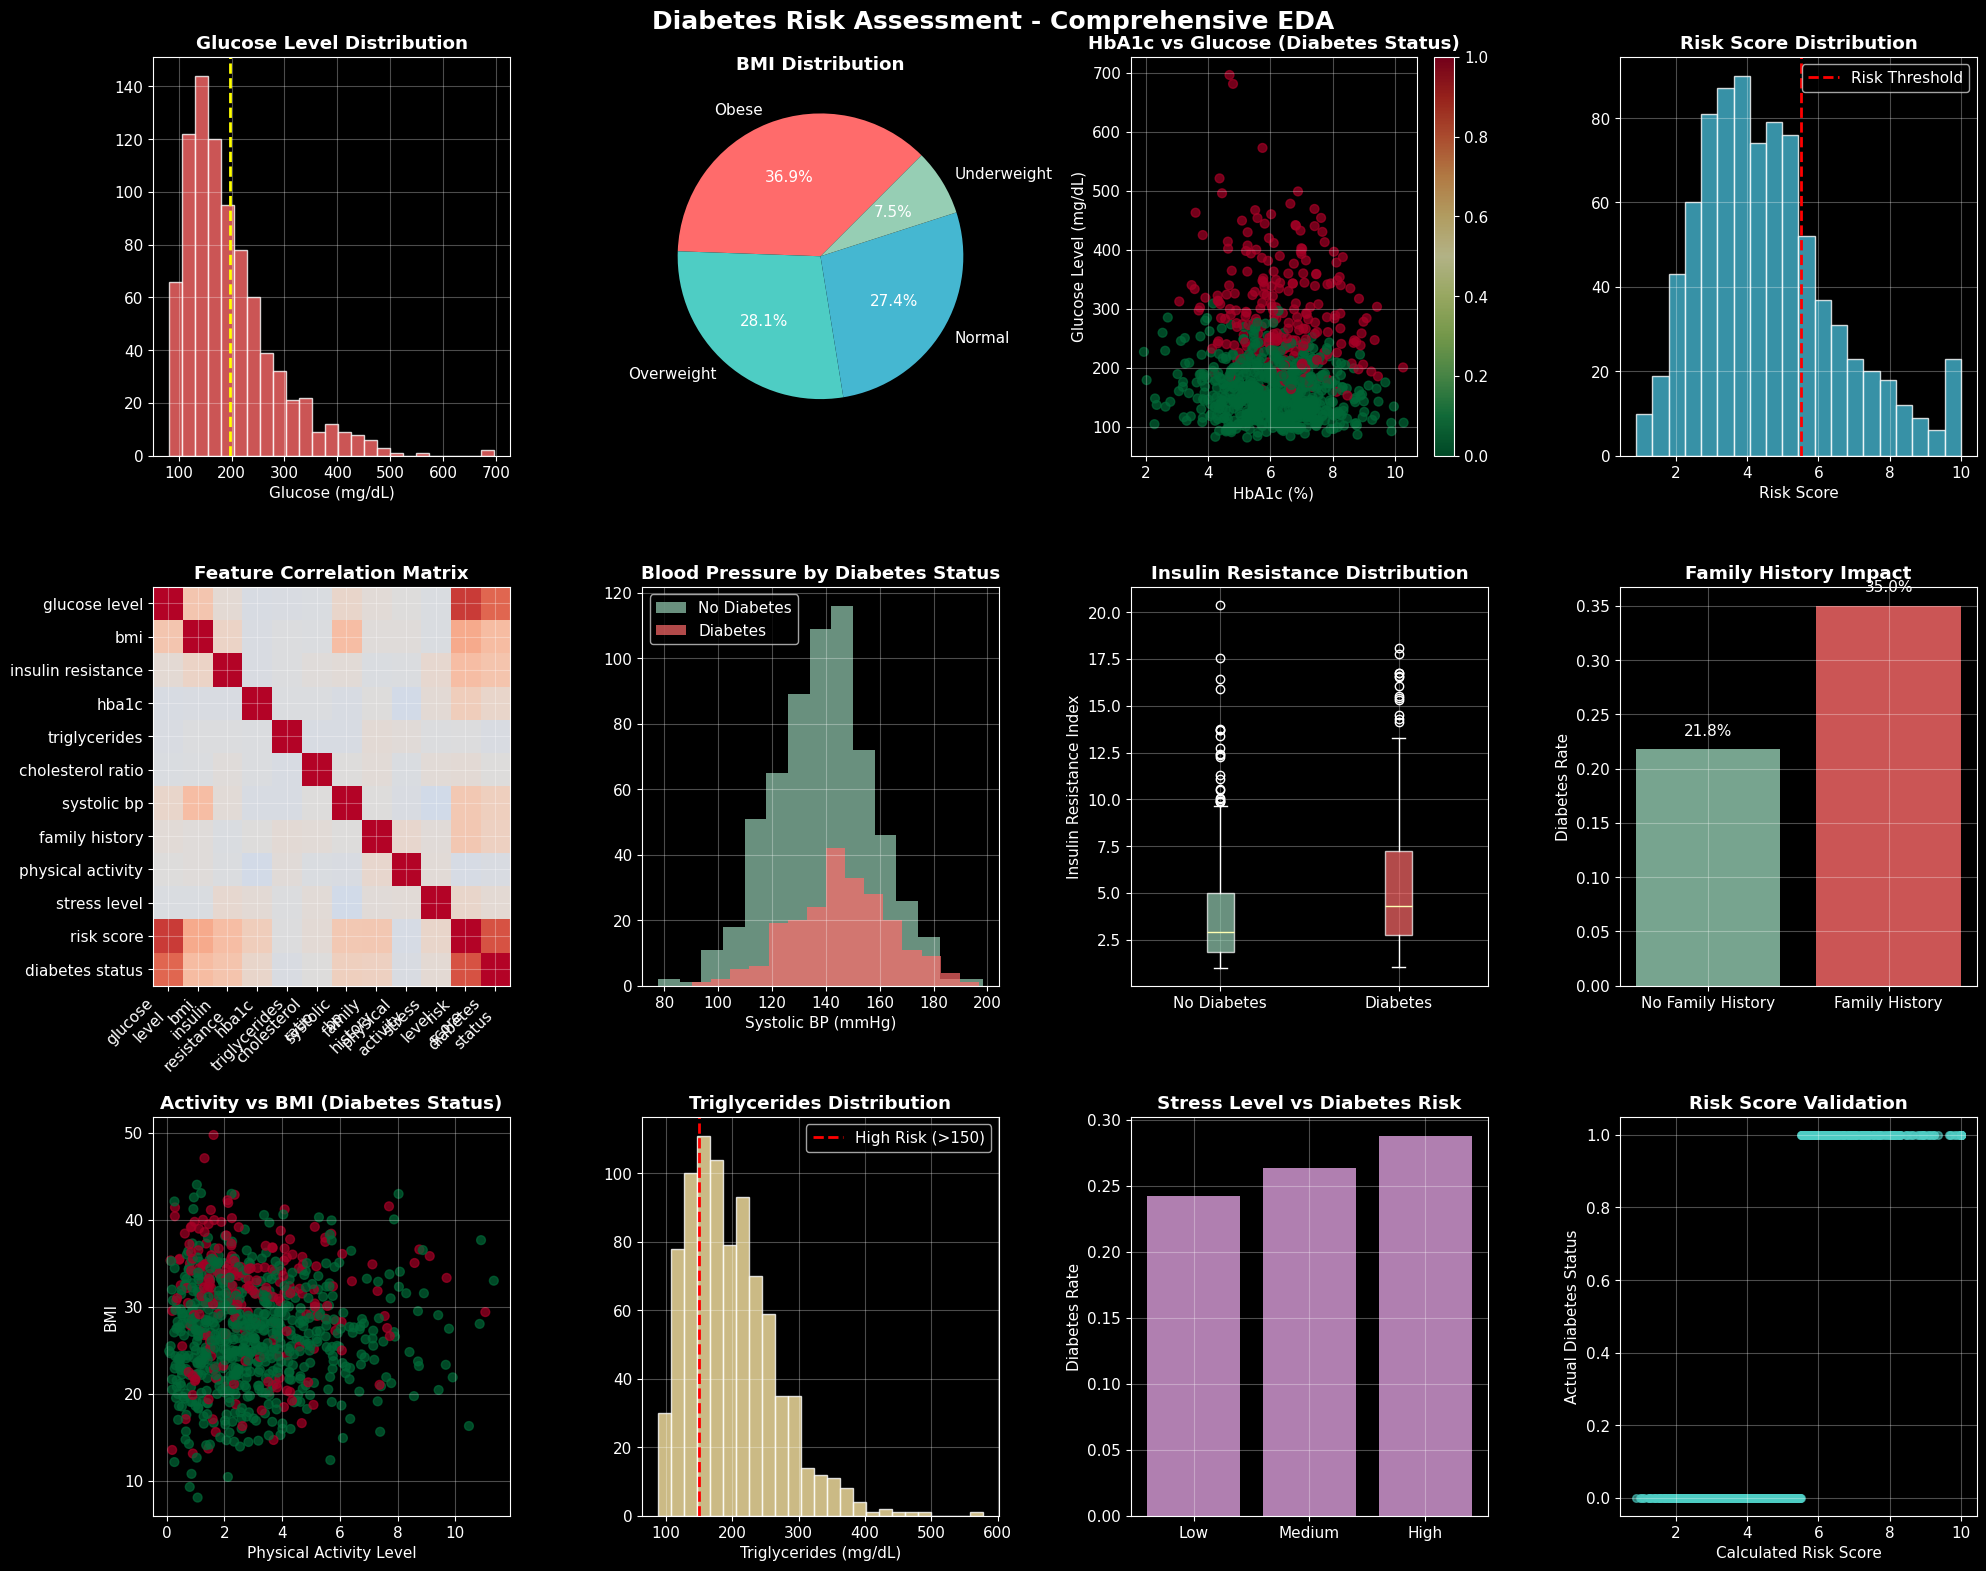

In [5]:
fig, axes = plt.subplots(3, 4, figsize=(20, 16))
fig.suptitle('Diabetes Risk Assessment - Comprehensive EDA', fontsize=18, fontweight='bold', color='white')

axes[0,0].hist(diabetes_df['glucose_level'], bins=25, alpha=0.8, color=colors[0], edgecolor='white')
axes[0,0].axvline(diabetes_df['glucose_level'].mean(), color='yellow', linestyle='--', linewidth=2)
axes[0,0].set_title('Glucose Level Distribution', fontweight='bold')
axes[0,0].set_xlabel('Glucose (mg/dL)')

bmi_categories = pd.cut(diabetes_df['bmi'], bins=[0, 18.5, 25, 30, float('inf')],
                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
bmi_counts = bmi_categories.value_counts()
wedges, texts, autotexts = axes[0,1].pie(bmi_counts.values, labels=bmi_counts.index,
                                        autopct='%1.1f%%', colors=colors[:4], startangle=45)
axes[0,1].set_title('BMI Distribution', fontweight='bold')

scatter = axes[0,2].scatter(diabetes_df['hba1c'], diabetes_df['glucose_level'],
                           c=diabetes_df['diabetes_status'], cmap='RdYlGn_r', alpha=0.7, s=40)
axes[0,2].set_xlabel('HbA1c (%)')
axes[0,2].set_ylabel('Glucose Level (mg/dL)')
axes[0,2].set_title('HbA1c vs Glucose (Diabetes Status)', fontweight='bold')
plt.colorbar(scatter, ax=axes[0,2])

axes[0,3].hist(diabetes_df['risk_score'], bins=20, alpha=0.8, color=colors[2], edgecolor='white')
axes[0,3].axvline(5.5, color='red', linestyle='--', linewidth=2, label='Risk Threshold')
axes[0,3].set_title('Risk Score Distribution', fontweight='bold')
axes[0,3].set_xlabel('Risk Score')
axes[0,3].legend()

numeric_features = diabetes_df.select_dtypes(include=[np.number]).columns
corr_matrix = diabetes_df[numeric_features].corr()
im = axes[1,0].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1,0].set_xticks(range(len(numeric_features)))
axes[1,0].set_yticks(range(len(numeric_features)))
axes[1,0].set_xticklabels([col.replace('_', '\n') for col in numeric_features], rotation=45, ha='right')
axes[1,0].set_yticklabels([col.replace('_', ' ') for col in numeric_features])
axes[1,0].set_title('Feature Correlation Matrix', fontweight='bold')

bp_diabetes = diabetes_df[diabetes_df['diabetes_status']==1]['systolic_bp']
bp_normal = diabetes_df[diabetes_df['diabetes_status']==0]['systolic_bp']
axes[1,1].hist(bp_normal, bins=15, alpha=0.7, label='No Diabetes', color=colors[3])
axes[1,1].hist(bp_diabetes, bins=15, alpha=0.7, label='Diabetes', color=colors[0])
axes[1,1].set_xlabel('Systolic BP (mmHg)')
axes[1,1].set_title('Blood Pressure by Diabetes Status', fontweight='bold')
axes[1,1].legend()

diabetes_labels = ['No Diabetes', 'Diabetes']
ir_data = [diabetes_df[diabetes_df['diabetes_status']==i]['insulin_resistance'] for i in [0,1]]
box_plot = axes[1,2].boxplot(ir_data, labels=diabetes_labels, patch_artist=True)
for patch, color in zip(box_plot['boxes'], [colors[3], colors[0]]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1,2].set_title('Insulin Resistance Distribution', fontweight='bold')
axes[1,2].set_ylabel('Insulin Resistance Index')

family_risk = diabetes_df.groupby('family_history')['diabetes_status'].mean()
bars = axes[1,3].bar(['No Family History', 'Family History'], family_risk.values,
                    color=[colors[3], colors[0]], alpha=0.8)
axes[1,3].set_title('Family History Impact', fontweight='bold')
axes[1,3].set_ylabel('Diabetes Rate')
for bar, rate in zip(bars, family_risk.values):
    axes[1,3].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{rate:.1%}', ha='center', va='bottom')

scatter2 = axes[2,0].scatter(diabetes_df['physical_activity'], diabetes_df['bmi'],
                            c=diabetes_df['diabetes_status'], cmap='RdYlGn_r', alpha=0.7, s=40)
axes[2,0].set_xlabel('Physical Activity Level')
axes[2,0].set_ylabel('BMI')
axes[2,0].set_title('Activity vs BMI (Diabetes Status)', fontweight='bold')

axes[2,1].hist(diabetes_df['triglycerides'], bins=25, alpha=0.8, color=colors[4], edgecolor='white')
axes[2,1].axvline(150, color='red', linestyle='--', linewidth=2, label='High Risk (>150)')
axes[2,1].set_title('Triglycerides Distribution', fontweight='bold')
axes[2,1].set_xlabel('Triglycerides (mg/dL)')
axes[2,1].legend()

stress_bins = pd.cut(diabetes_df['stress_level'], bins=3, labels=['Low', 'Medium', 'High'])
stress_diabetes = diabetes_df.groupby(stress_bins)['diabetes_status'].mean()
axes[2,2].bar(stress_diabetes.index, stress_diabetes.values, color=colors[5], alpha=0.8)
axes[2,2].set_title('Stress Level vs Diabetes Risk', fontweight='bold')
axes[2,2].set_ylabel('Diabetes Rate')

axes[2,3].scatter(diabetes_df['risk_score'], diabetes_df['diabetes_status'],
                 alpha=0.6, color=colors[1], s=30)
axes[2,3].set_xlabel('Calculated Risk Score')
axes[2,3].set_ylabel('Actual Diabetes Status')
axes[2,3].set_title('Risk Score Validation', fontweight='bold')

plt.tight_layout()
plt.show()

# Feature Engineering and Preprocessing

Selected clustering variables: ['glucose_level', 'bmi', 'insulin_resistance', 'hba1c', 'triglycerides', 'systolic_bp', 'physical_activity', 'stress_level']
Missing values check:
glucose_level         0
bmi                   0
insulin_resistance    0
hba1c                 0
triglycerides         0
systolic_bp           0
physical_activity     0
stress_level          0
dtype: int64
Feature standardization completed
Normalized data shape: (850, 8)


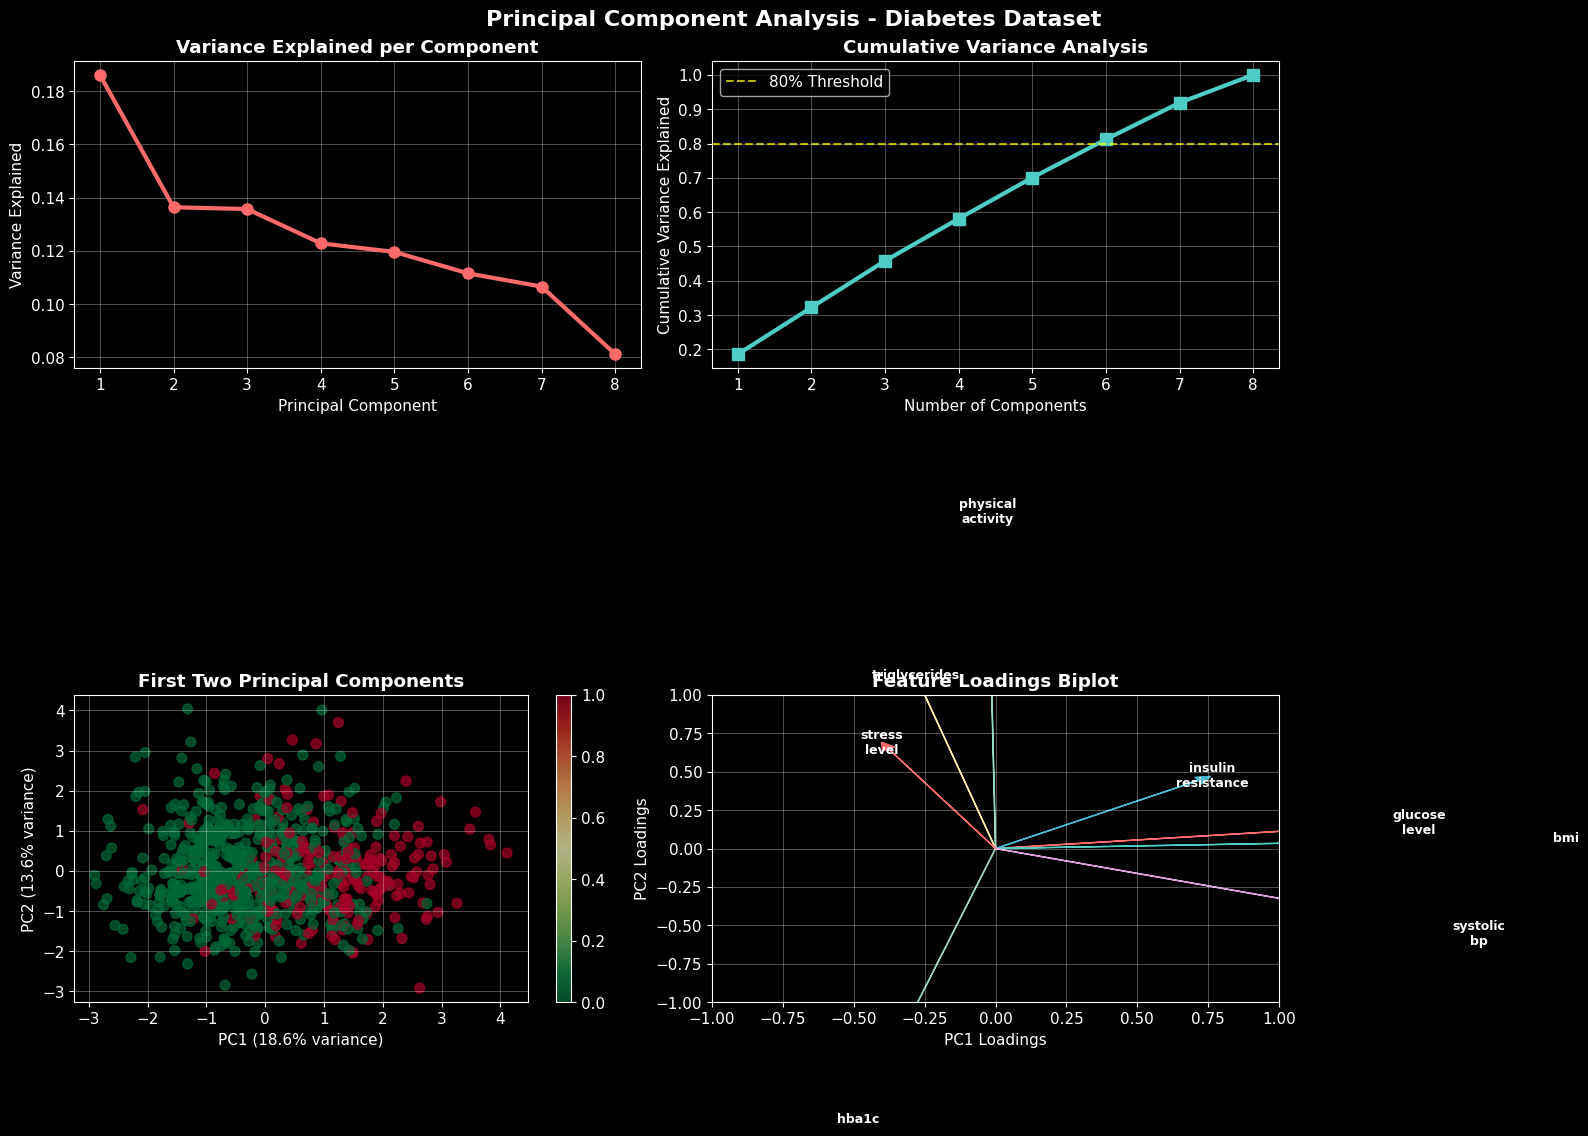

First two components explain 32.3% of total variance


In [6]:
clustering_vars = ['glucose_level', 'bmi', 'insulin_resistance', 'hba1c',
                  'triglycerides', 'systolic_bp', 'physical_activity', 'stress_level']

print(f"Selected clustering variables: {clustering_vars}")
X = diabetes_df[clustering_vars].copy()

print(f"Missing values check:")
print(X.isnull().sum())

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
print(f"Feature standardization completed")
print(f"Normalized data shape: {X_normalized.shape}")

pca = PCA()
X_pca = pca.fit_transform(X_normalized)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Principal Component Analysis - Diabetes Dataset', fontsize=16, fontweight='bold')

axes[0,0].plot(range(1, len(pca.explained_variance_ratio_) + 1),
               pca.explained_variance_ratio_, 'o-', color=colors[0], linewidth=3, markersize=8)
axes[0,0].set_xlabel('Principal Component')
axes[0,0].set_ylabel('Variance Explained')
axes[0,0].set_title('Variance Explained per Component', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

cumulative_var = np.cumsum(pca.explained_variance_ratio_)
axes[0,1].plot(range(1, len(cumulative_var) + 1), cumulative_var,
               's-', color=colors[1], linewidth=3, markersize=8)
axes[0,1].axhline(y=0.8, color='yellow', linestyle='--', alpha=0.7, label='80% Threshold')
axes[0,1].set_xlabel('Number of Components')
axes[0,1].set_ylabel('Cumulative Variance Explained')
axes[0,1].set_title('Cumulative Variance Analysis', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

scatter = axes[1,0].scatter(X_pca[:, 0], X_pca[:, 1], c=diabetes_df['diabetes_status'],
                           cmap='RdYlGn_r', alpha=0.7, s=50)
axes[1,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[1,0].set_title('First Two Principal Components', fontweight='bold')
plt.colorbar(scatter, ax=axes[1,0])

feature_loadings = pd.DataFrame(
    pca.components_[:2].T,
    columns=['PC1', 'PC2'],
    index=clustering_vars
)

for i, (feature, loading) in enumerate(feature_loadings.iterrows()):
    axes[1,1].arrow(0, 0, loading['PC1']*3, loading['PC2']*3,
                   head_width=0.05, head_length=0.05, fc=colors[i%7], ec=colors[i%7])
    axes[1,1].text(loading['PC1']*3.2, loading['PC2']*3.2, feature.replace('_', '\n'),
                  ha='center', va='center', fontsize=9, fontweight='bold')

axes[1,1].set_xlim(-1, 1)
axes[1,1].set_ylim(-1, 1)
axes[1,1].set_xlabel('PC1 Loadings')
axes[1,1].set_ylabel('PC2 Loadings')
axes[1,1].set_title('Feature Loadings Biplot', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"First two components explain {cumulative_var[1]:.1%} of total variance")

def optimize_kmeans(data, max_clusters=8):
    """Optimized K-means evaluation with multiple metrics"""
    cluster_range = range(2, max_clusters + 1)
    inertias = []
    silhouette_scores = []
    calinski_scores = []

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=2024, n_init=10, max_iter=300)
        cluster_labels = kmeans.fit_predict(data)

        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, cluster_labels))
        calinski_scores.append(calinski_harabasz_score(data, cluster_labels))

    return cluster_range, inertias, silhouette_scores, calinski_scores

cluster_range, inertias, sil_scores, cal_scores = optimize_kmeans(X_normalized)

# Visualization of clustering metrics

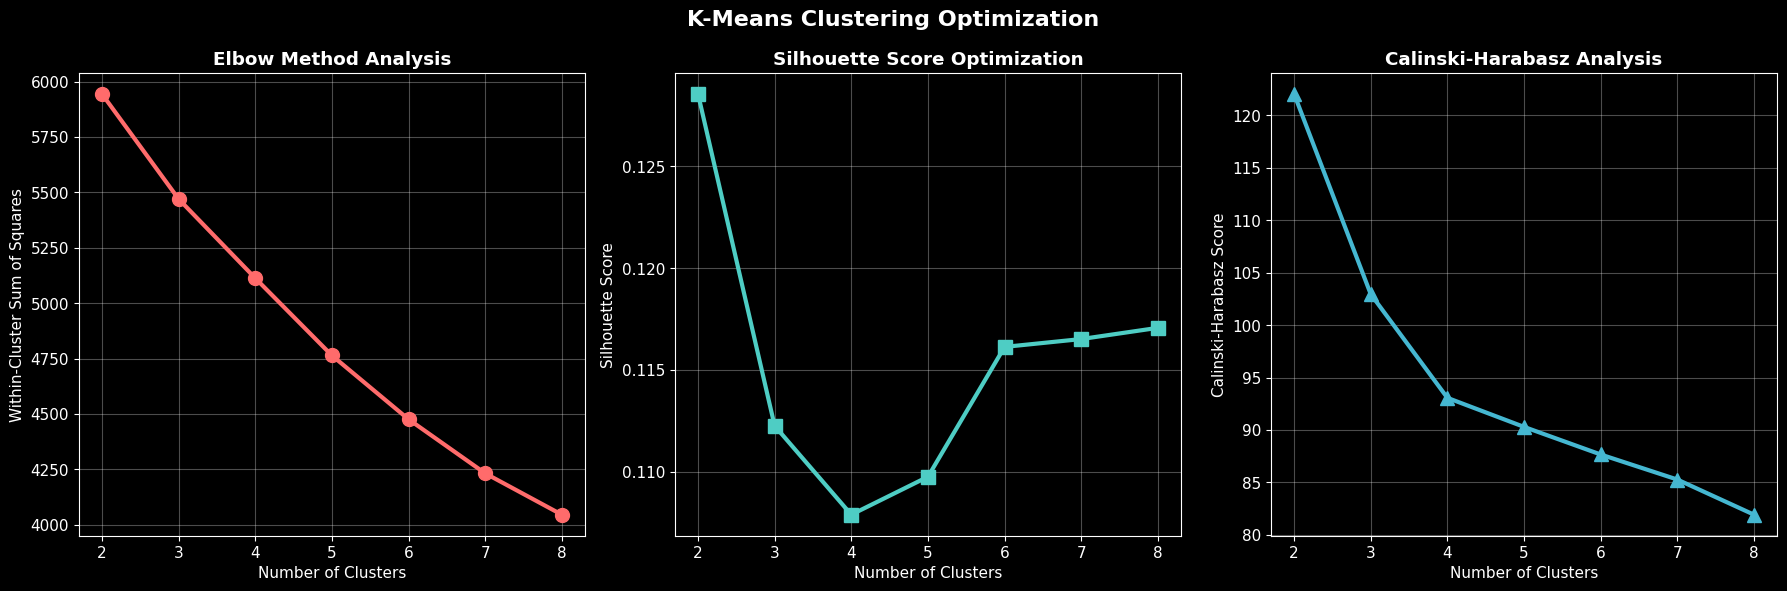

Optimal number of clusters: 2
Best silhouette score: 0.129
Final K-Means Results:
   Clusters: 2
   Silhouette Score: 0.129
   Calinski-Harabasz Score: 122.052


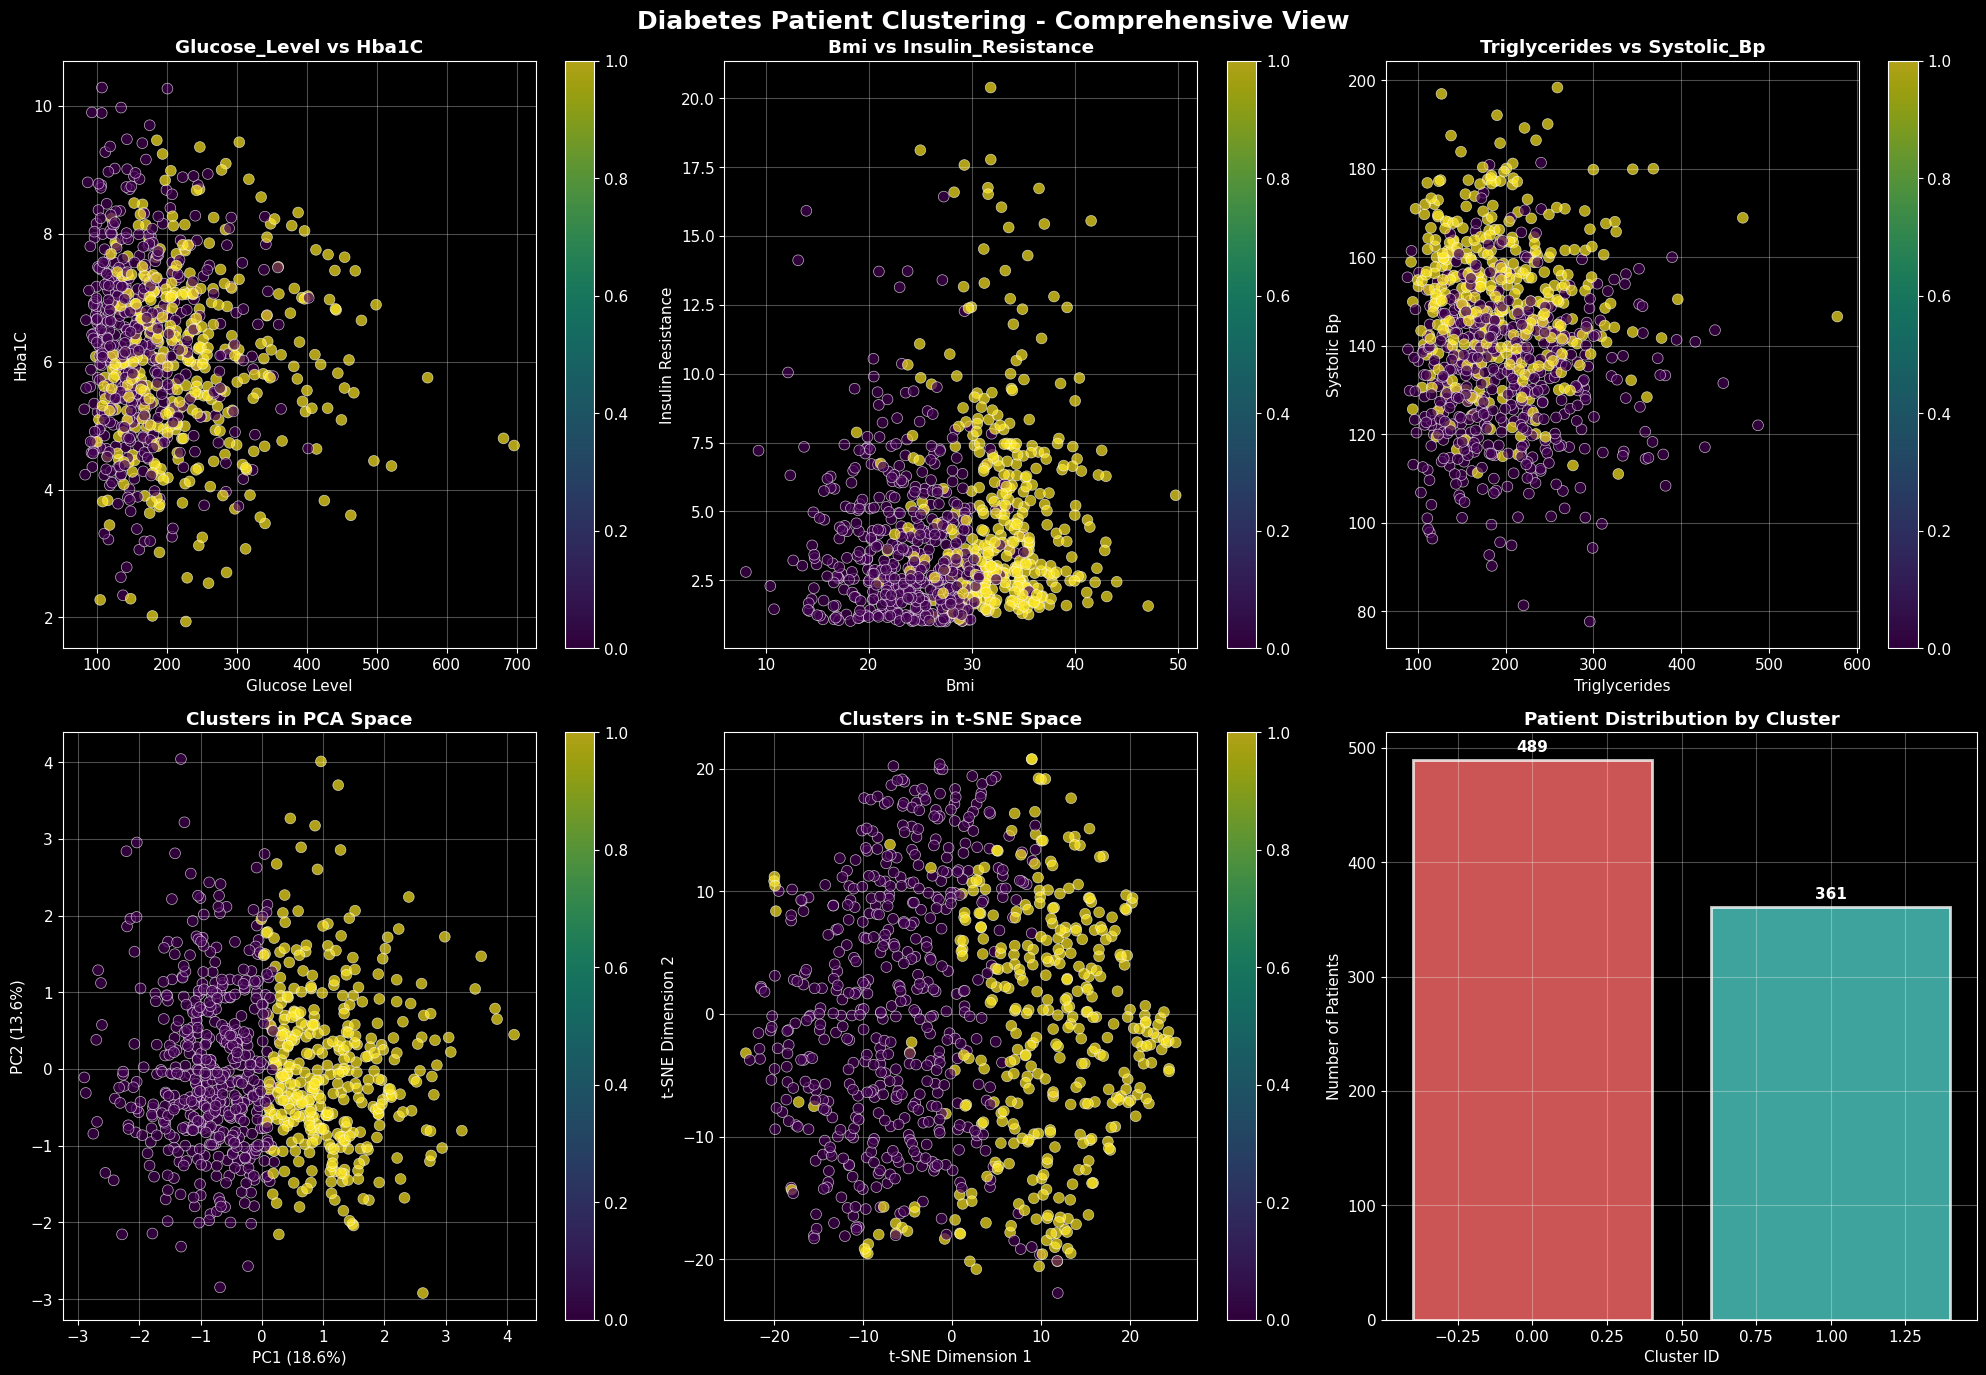

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('K-Means Clustering Optimization', fontsize=16, fontweight='bold')

axes[0].plot(cluster_range, inertias, 'o-', color=colors[0], linewidth=3, markersize=10)
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Within-Cluster Sum of Squares')
axes[0].set_title('Elbow Method Analysis', fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(cluster_range, sil_scores, 's-', color=colors[1], linewidth=3, markersize=10)
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score Optimization', fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(cluster_range, cal_scores, '^-', color=colors[2], linewidth=3, markersize=10)
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Calinski-Harabasz Analysis', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k = cluster_range[np.argmax(sil_scores)]
print(f"Optimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {max(sil_scores):.3f}")

final_kmeans = KMeans(n_clusters=optimal_k, random_state=2024, n_init=10)
cluster_assignments = final_kmeans.fit_predict(X_normalized)

diabetes_df['patient_cluster'] = cluster_assignments

final_silhouette = silhouette_score(X_normalized, cluster_assignments)
final_calinski = calinski_harabasz_score(X_normalized, cluster_assignments)

print(f"Final K-Means Results:")
print(f"   Clusters: {optimal_k}")
print(f"   Silhouette Score: {final_silhouette:.3f}")
print(f"   Calinski-Harabasz Score: {final_calinski:.3f}")

fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Diabetes Patient Clustering - Comprehensive View', fontsize=18, fontweight='bold')

feature_combinations = [
    ('glucose_level', 'hba1c'),
    ('bmi', 'insulin_resistance'),
    ('triglycerides', 'systolic_bp')
]

for idx, (feat1, feat2) in enumerate(feature_combinations):
    scatter = axes[0, idx].scatter(diabetes_df[feat1], diabetes_df[feat2],
                                  c=cluster_assignments, cmap='viridis',
                                  alpha=0.7, s=60, edgecolors='white', linewidth=0.5)
    axes[0, idx].set_xlabel(feat1.replace('_', ' ').title())
    axes[0, idx].set_ylabel(feat2.replace('_', ' ').title())
    axes[0, idx].set_title(f'{feat1.title()} vs {feat2.title()}', fontweight='bold')
    plt.colorbar(scatter, ax=axes[0, idx])

scatter = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_assignments,
                            cmap='viridis', alpha=0.7, s=60, edgecolors='white', linewidth=0.5)
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1, 0].set_title('Clusters in PCA Space', fontweight='bold')
plt.colorbar(scatter, ax=axes[1, 0])

tsne = TSNE(n_components=2, random_state=2024, perplexity=40, n_iter=400)
X_tsne = tsne.fit_transform(X_normalized)
scatter = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_assignments,
                            cmap='viridis', alpha=0.7, s=60, edgecolors='white', linewidth=0.5)
axes[1, 1].set_xlabel('t-SNE Dimension 1')
axes[1, 1].set_ylabel('t-SNE Dimension 2')
axes[1, 1].set_title('Clusters in t-SNE Space', fontweight='bold')
plt.colorbar(scatter, ax=axes[1, 1])

cluster_sizes = np.bincount(cluster_assignments)
bars = axes[1, 2].bar(range(optimal_k), cluster_sizes,
                     color=colors[:optimal_k], alpha=0.8, edgecolor='white', linewidth=2)
axes[1, 2].set_xlabel('Cluster ID')
axes[1, 2].set_ylabel('Number of Patients')
axes[1, 2].set_title('Patient Distribution by Cluster', fontweight='bold')
for bar, size in zip(bars, cluster_sizes):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                   f'{size}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Clinical Profile Analysis by Cluster

Clinical Profile Analysis by Patient Cluster
 Detailed Cluster Statistics:
                glucose_level           bmi       insulin_resistance        \
                         mean    std   mean   std               mean   std   
patient_cluster                                                              
0                      165.76  60.28  23.80  4.65               3.62  2.47   
1                      238.19  97.51  33.02  4.39               5.03  3.60   

                hba1c       triglycerides         ... systolic_bp  \
                 mean   std          mean    std  ...         std   
patient_cluster                                   ...               
0                6.33  1.40        200.73  68.39  ...       16.07   
1                5.98  1.39        195.12  65.08  ...       15.91   

                physical_activity       stress_level       diabetes_status  \
                             mean   std         mean   std           count   
patient_cluster                 

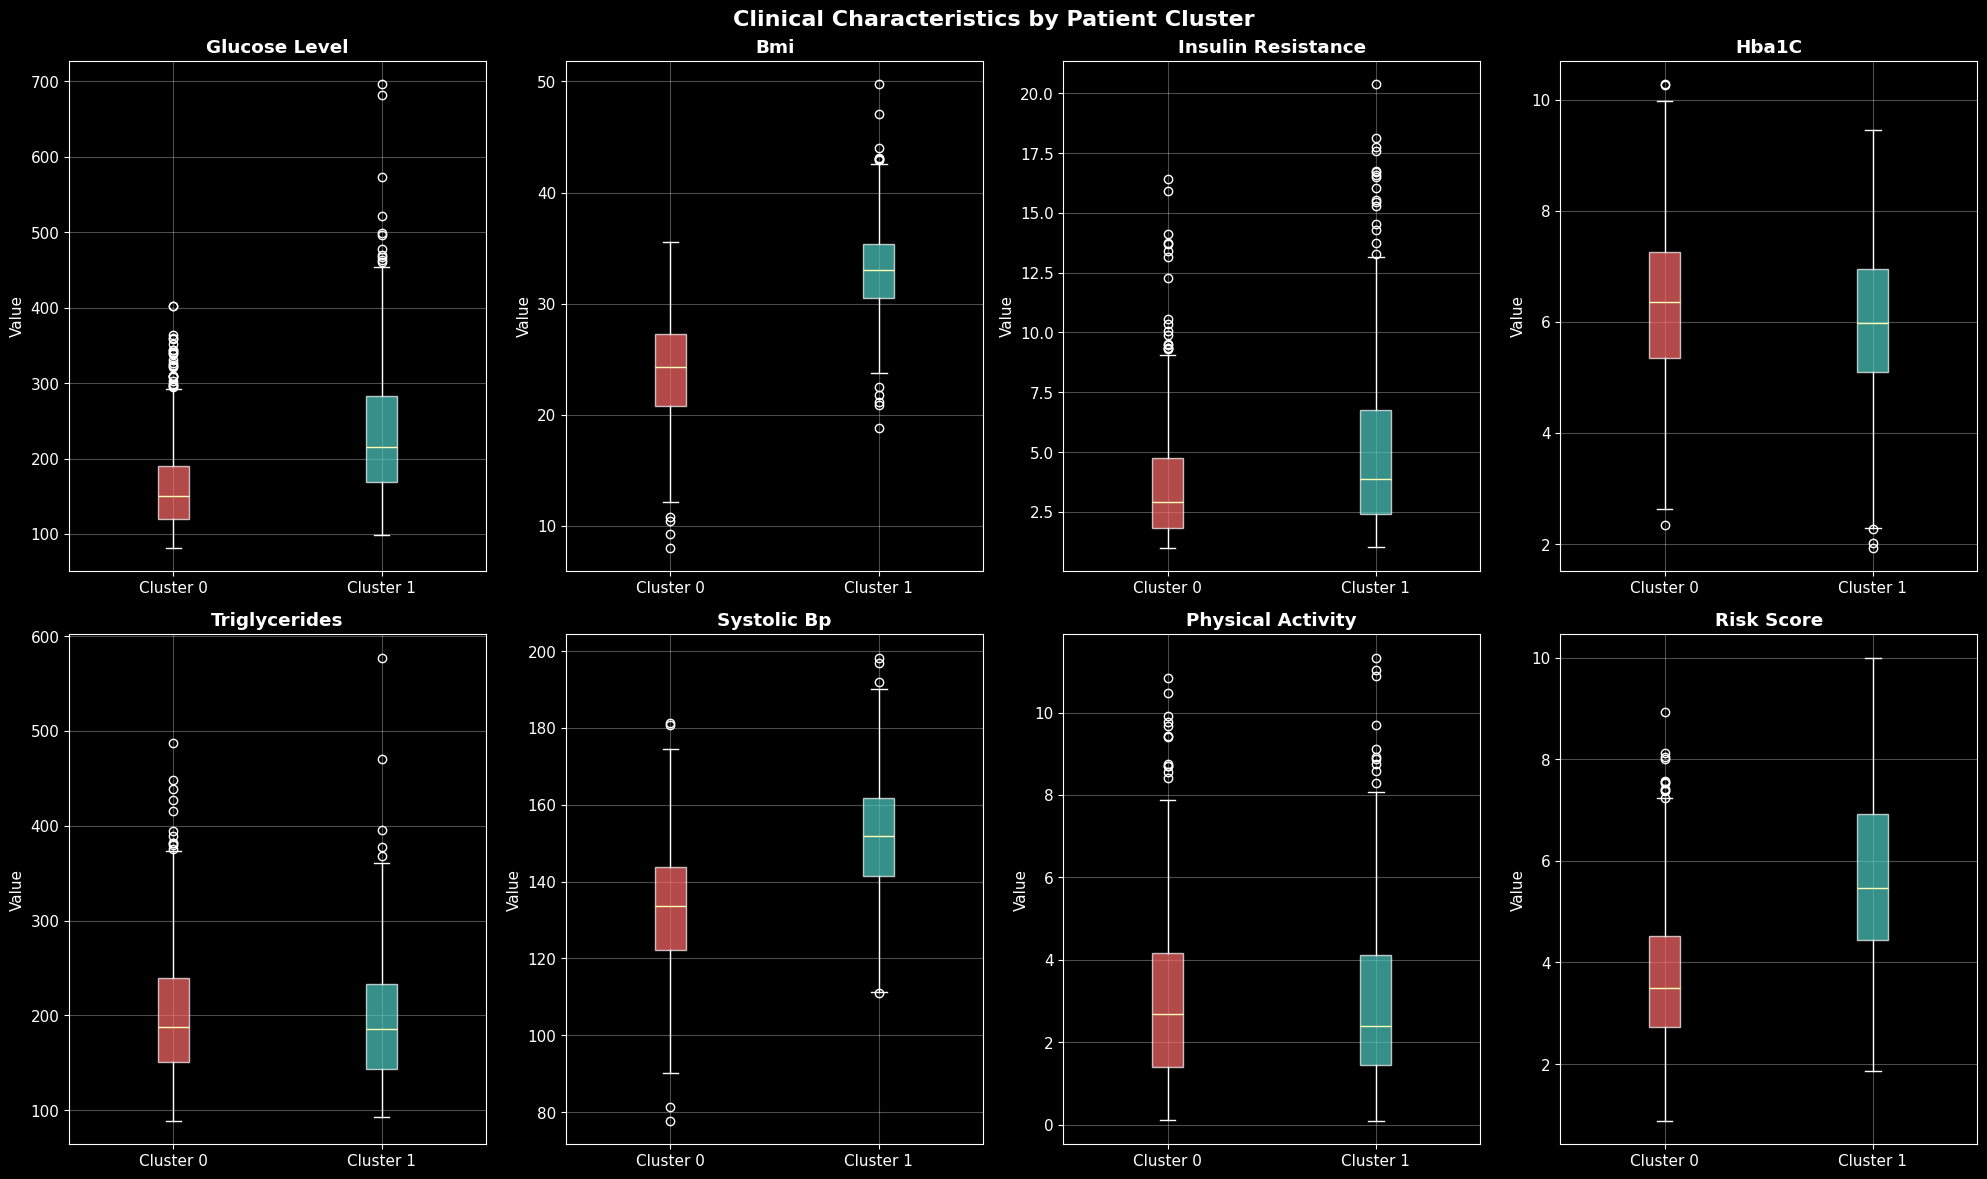

In [8]:
def analyze_patient_clusters(dataframe, cluster_col='patient_cluster'):
    """Comprehensive clinical analysis of patient clusters"""

    print("Clinical Profile Analysis by Patient Cluster")
    print("=" * 55)

    cluster_profiles = dataframe.groupby(cluster_col)[clustering_vars + ['diabetes_status', 'risk_score']].agg({
        'glucose_level': ['mean', 'std'],
        'bmi': ['mean', 'std'],
        'insulin_resistance': ['mean', 'std'],
        'hba1c': ['mean', 'std'],
        'triglycerides': ['mean', 'std'],
        'systolic_bp': ['mean', 'std'],
        'physical_activity': ['mean', 'std'],
        'stress_level': ['mean', 'std'],
        'diabetes_status': ['count', 'sum', 'mean'],
        'risk_score': ['mean', 'std']
    }).round(2)

    print(" Detailed Cluster Statistics:")
    print(cluster_profiles)

    risk_analysis = dataframe.groupby(cluster_col).agg({
        'diabetes_status': 'mean',
        'risk_score': 'mean',
        'glucose_level': 'mean',
        'bmi': 'mean',
        'hba1c': 'mean'
    }).round(3)

    risk_analysis['risk_category'] = pd.cut(
        risk_analysis['diabetes_status'],
        bins=[0, 0.3, 0.6, 1.0],
        labels=['Low Risk', 'Moderate Risk', 'High Risk']
    )

    print(f"\nRisk Stratification by Cluster:")
    print(risk_analysis)

    return cluster_profiles, risk_analysis

cluster_profiles, risk_stratification = analyze_patient_clusters(diabetes_df)

fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Clinical Characteristics by Patient Cluster', fontsize=16, fontweight='bold')

key_features = ['glucose_level', 'bmi', 'insulin_resistance', 'hba1c',
               'triglycerides', 'systolic_bp', 'physical_activity', 'risk_score']

for idx, feature in enumerate(key_features):
    ax = axes[idx//4, idx%4]

    cluster_data = [diabetes_df[diabetes_df['patient_cluster']==c][feature].values
                   for c in sorted(diabetes_df['patient_cluster'].unique())]

    box_plot = ax.boxplot(cluster_data, patch_artist=True,
                         labels=[f'Cluster {i}' for i in range(len(cluster_data))])

    for patch, color in zip(box_plot['boxes'], colors[:len(cluster_data)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('white')

    ax.set_title(feature.replace('_', ' ').title(), fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Advanced Risk Assessment and Clinical Recommendations

In [9]:
def generate_clinical_insights(dataframe, risk_data):
    """Generate comprehensive clinical insights and recommendations"""

    print("Clinical Insights and Treatment Recommendations")
    print("=" * 52)

    recommendations = {}

    for cluster_id in sorted(dataframe['patient_cluster'].unique()):
        cluster_patients = dataframe[dataframe['patient_cluster'] == cluster_id]
        cluster_risk = risk_data.loc[cluster_id]

        print(f"\nCLUSTER {cluster_id} - Patient Profile Analysis")
        print(f"   Patient Count: {len(cluster_patients)}")
        print(f"   Diabetes Prevalence: {cluster_risk['diabetes_status']:.1%}")
        print(f"   Average Risk Score: {cluster_risk['risk_score']:.2f}/10")
        print(f"   Mean Glucose: {cluster_risk['glucose_level']:.1f} mg/dL")
        print(f"   Mean BMI: {cluster_risk['bmi']:.1f}")
        print(f"   Mean HbA1c: {cluster_risk['hba1c']:.1f}%")

        recs = []

        if cluster_risk['diabetes_status'] > 0.7:
            recs.append("HIGH RISK - Immediate intervention required")
            recs.append("   → Intensive diabetes management program")
            recs.append("   → Weekly glucose monitoring")
            recs.append("   → Medication optimization review")
        elif cluster_risk['diabetes_status'] > 0.4:
            recs.append("MODERATE RISK - Enhanced monitoring needed")
            recs.append("   → Monthly follow-ups recommended")
            recs.append("   → Lifestyle modification counseling")
        else:
            recs.append("LOW RISK - Preventive care focus")
            recs.append("   → Annual screening sufficient")
            recs.append("   → Health maintenance education")

        if cluster_risk['bmi'] > 30:
            recs.append("   → Weight management program referral")

        if cluster_risk['glucose_level'] > 125:
            recs.append("   → Glucose management intervention")

        if cluster_risk['hba1c'] > 7.0:
            recs.append("   → HbA1c optimization required")

        recommendations[cluster_id] = recs

        print("   Clinical Recommendations:")
        for rec in recs:
            print(f"   {rec}")

    return recommendations

clinical_recommendations = generate_clinical_insights(diabetes_df, risk_stratification)

Clinical Insights and Treatment Recommendations

CLUSTER 0 - Patient Profile Analysis
   Patient Count: 489
   Diabetes Prevalence: 10.0%
   Average Risk Score: 3.68/10
   Mean Glucose: 165.8 mg/dL
   Mean BMI: 23.8
   Mean HbA1c: 6.3%
   Clinical Recommendations:
   LOW RISK - Preventive care focus
      → Annual screening sufficient
      → Health maintenance education
      → Glucose management intervention

CLUSTER 1 - Patient Profile Analysis
   Patient Count: 361
   Diabetes Prevalence: 48.8%
   Average Risk Score: 5.78/10
   Mean Glucose: 238.2 mg/dL
   Mean BMI: 33.0
   Mean HbA1c: 6.0%
   Clinical Recommendations:
   MODERATE RISK - Enhanced monitoring needed
      → Monthly follow-ups recommended
      → Lifestyle modification counseling
      → Weight management program referral
      → Glucose management intervention


# Comprehensive Results Dashboard

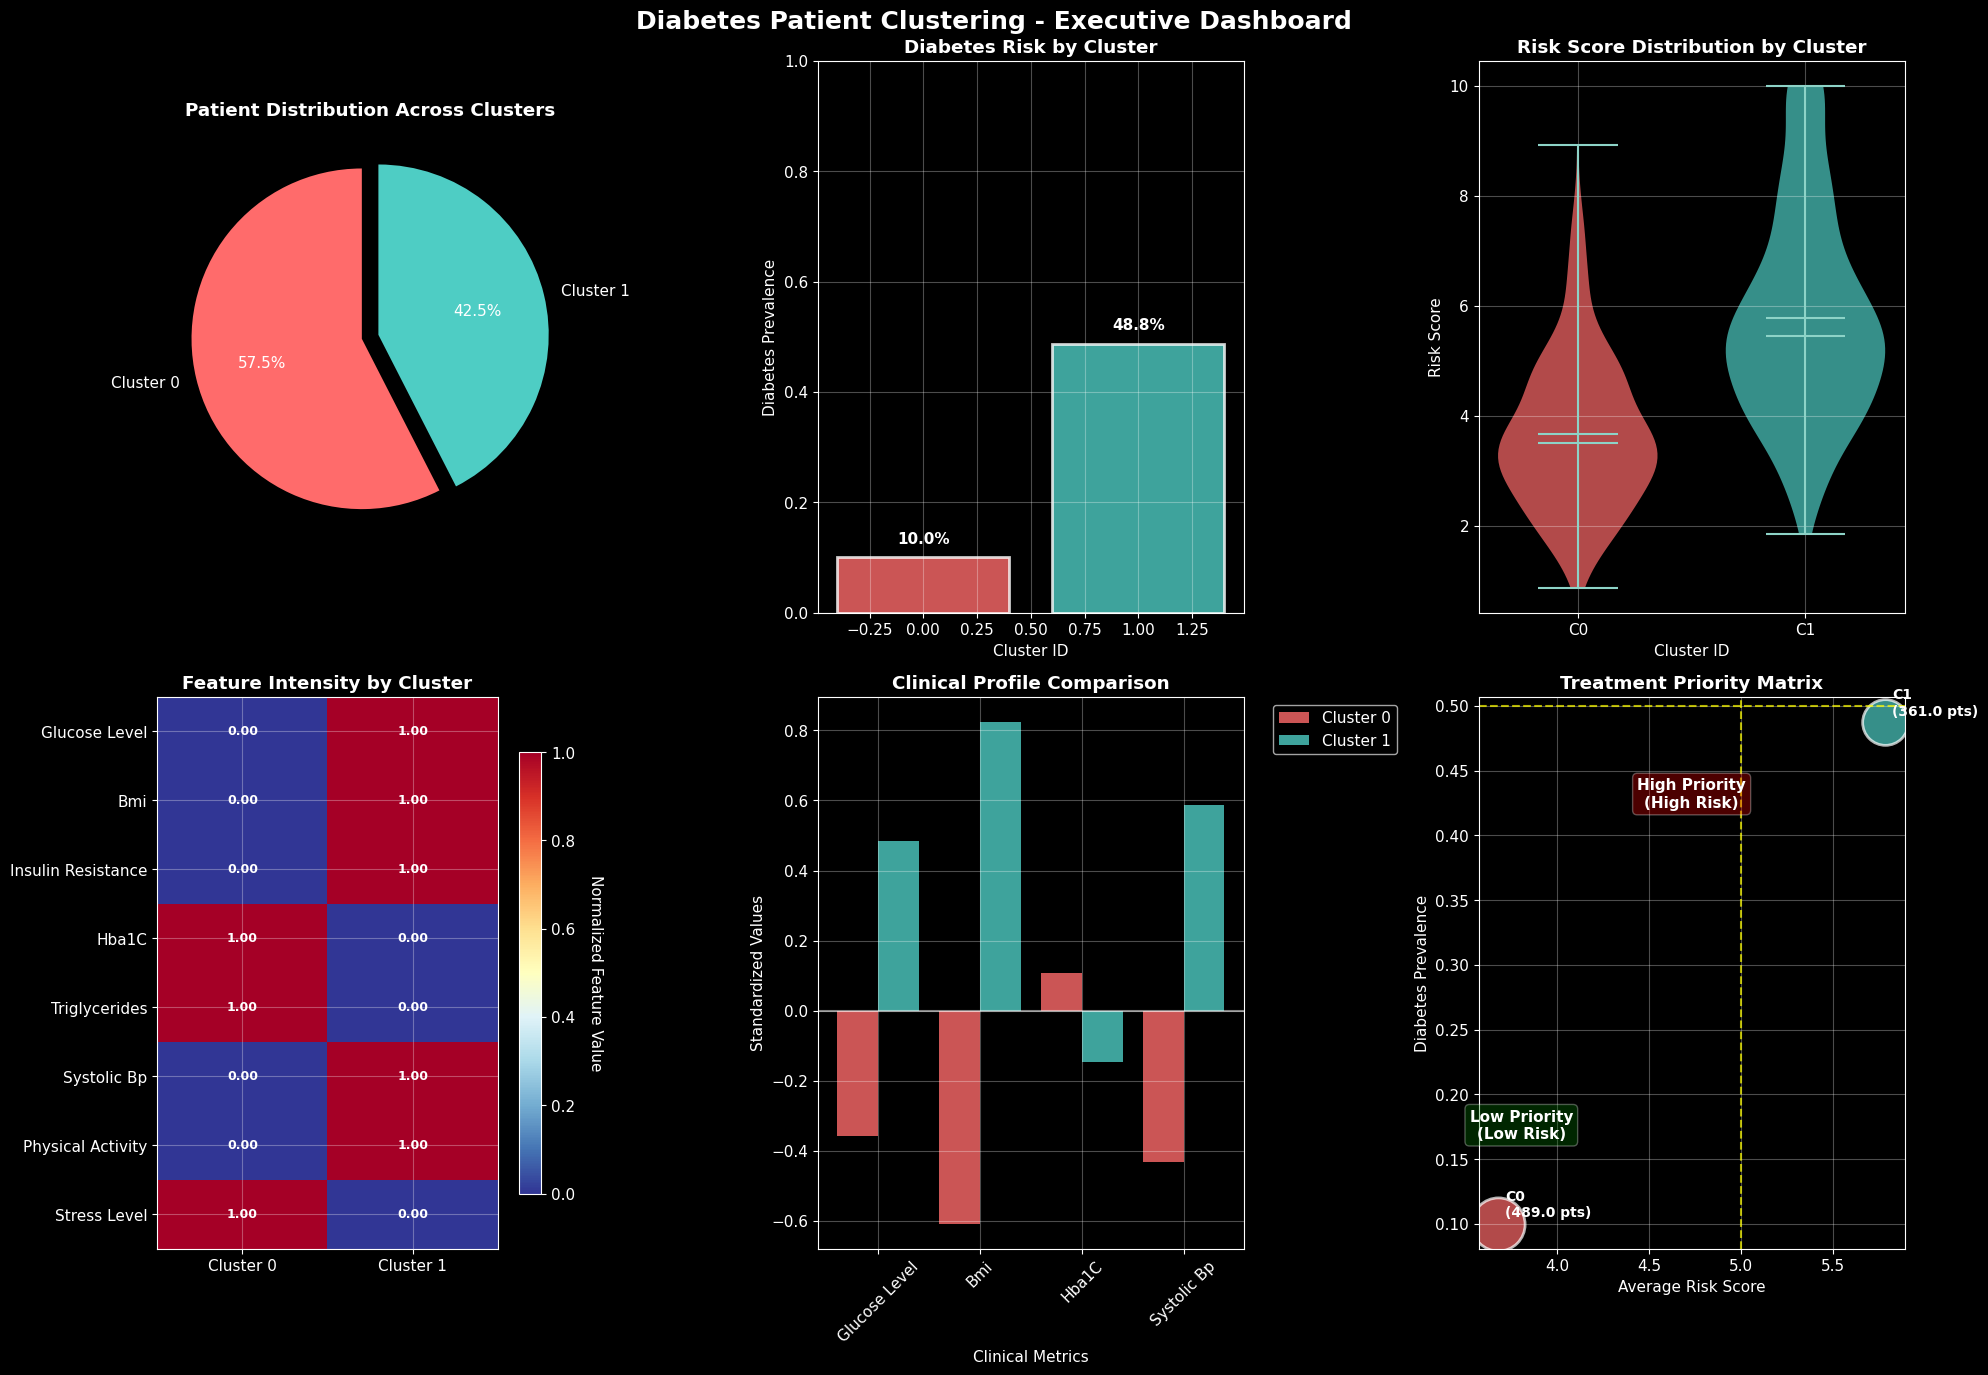

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Diabetes Patient Clustering - Executive Dashboard', fontsize=18, fontweight='bold')

cluster_dist = diabetes_df['patient_cluster'].value_counts().sort_index()
wedges, texts, autotexts = axes[0,0].pie(cluster_dist.values,
                                        labels=[f'Cluster {i}' for i in cluster_dist.index],
                                        autopct='%1.1f%%', colors=colors[:len(cluster_dist)],
                                        startangle=90, explode=[0.05]*len(cluster_dist))
axes[0,0].set_title('Patient Distribution Across Clusters', fontweight='bold')

diabetes_rates = diabetes_df.groupby('patient_cluster')['diabetes_status'].mean()
bars = axes[0,1].bar(diabetes_rates.index, diabetes_rates.values,
                    color=colors[:len(diabetes_rates)], alpha=0.8, edgecolor='white', linewidth=2)
axes[0,1].set_xlabel('Cluster ID')
axes[0,1].set_ylabel('Diabetes Prevalence')
axes[0,1].set_title('Diabetes Risk by Cluster', fontweight='bold')
axes[0,1].set_ylim(0, 1)
for bar, rate in zip(bars, diabetes_rates.values):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{rate:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=11)

risk_by_cluster = [diabetes_df[diabetes_df['patient_cluster']==c]['risk_score'].values
                   for c in sorted(diabetes_df['patient_cluster'].unique())]
violin_parts = axes[0,2].violinplot(risk_by_cluster, positions=range(len(risk_by_cluster)),
                                   widths=0.7, showmeans=True, showmedians=True)
for pc, color in zip(violin_parts['bodies'], colors[:len(risk_by_cluster)]):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
axes[0,2].set_xlabel('Cluster ID')
axes[0,2].set_ylabel('Risk Score')
axes[0,2].set_title('Risk Score Distribution by Cluster', fontweight='bold')
axes[0,2].set_xticks(range(len(risk_by_cluster)))
axes[0,2].set_xticklabels([f'C{i}' for i in range(len(risk_by_cluster))])
axes[0,2].grid(True, alpha=0.3)

feature_means = diabetes_df.groupby('patient_cluster')[clustering_vars].mean()
normalized_means = (feature_means - feature_means.min()) / (feature_means.max() - feature_means.min())
im = axes[1,0].imshow(normalized_means.T, cmap='RdYlBu_r', aspect='auto')
axes[1,0].set_xticks(range(len(normalized_means)))
axes[1,0].set_yticks(range(len(clustering_vars)))
axes[1,0].set_xticklabels([f'Cluster {i}' for i in normalized_means.index])
axes[1,0].set_yticklabels([var.replace('_', ' ').title() for var in clustering_vars])
axes[1,0].set_title('Feature Intensity by Cluster', fontweight='bold')
cbar = plt.colorbar(im, ax=axes[1,0], shrink=0.8)
cbar.set_label('Normalized Feature Value', rotation=270, labelpad=20)
for i in range(len(normalized_means)):
    for j in range(len(clustering_vars)):
        text = axes[1,0].text(i, j, f'{normalized_means.iloc[i, j]:.2f}',
                             ha='center', va='center', color='white', fontweight='bold', fontsize=9)

clinical_metrics = ['glucose_level', 'bmi', 'hba1c', 'systolic_bp']
x_pos = np.arange(len(clinical_metrics))
width = 0.8 / len(diabetes_rates)
for i, cluster_id in enumerate(sorted(diabetes_df['patient_cluster'].unique())):
    cluster_data = diabetes_df[diabetes_df['patient_cluster'] == cluster_id]
    values = [cluster_data[metric].mean() for metric in clinical_metrics]
    normalized_values = [(val - diabetes_df[metric].mean()) / diabetes_df[metric].std()
                        for val, metric in zip(values, clinical_metrics)]
    bars = axes[1,1].bar(x_pos + i*width, normalized_values, width,
                        label=f'Cluster {cluster_id}', color=colors[i], alpha=0.8)

axes[1,1].set_xlabel('Clinical Metrics')
axes[1,1].set_ylabel('Standardized Values')
axes[1,1].set_title('Clinical Profile Comparison', fontweight='bold')
axes[1,1].set_xticks(x_pos + width * (len(diabetes_rates)-1) / 2)
axes[1,1].set_xticklabels([metric.replace('_', ' ').title() for metric in clinical_metrics], rotation=45)
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].grid(True, alpha=0.3, axis='y')
axes[1,1].axhline(y=0, color='white', linestyle='-', alpha=0.5)

priority_data = diabetes_df.groupby('patient_cluster').agg({
    'diabetes_status': 'mean',
    'risk_score': 'mean',
    'patient_cluster': 'count'
}).rename(columns={'patient_cluster': 'patient_count'})

for idx, (cluster_id, data) in enumerate(priority_data.iterrows()):
    bubble_size = data['patient_count'] * 3
    axes[1,2].scatter(data['risk_score'], data['diabetes_status'],
                     s=bubble_size, alpha=0.7, color=colors[idx],
                     edgecolors='white', linewidth=2, label=f'Cluster {cluster_id}')
    axes[1,2].annotate(f'C{cluster_id}\n({data["patient_count"]} pts)',
                      (data['risk_score'], data['diabetes_status']),
                      xytext=(5, 5), textcoords='offset points',
                      fontweight='bold', fontsize=10, ha='left')

axes[1,2].set_xlabel('Average Risk Score')
axes[1,2].set_ylabel('Diabetes Prevalence')
axes[1,2].set_title('Treatment Priority Matrix', fontweight='bold')
axes[1,2].grid(True, alpha=0.3)
axes[1,2].axhline(y=0.5, color='yellow', linestyle='--', alpha=0.7)
axes[1,2].axvline(x=5.0, color='yellow', linestyle='--', alpha=0.7)
axes[1,2].text(0.5, 0.8, 'High Priority\n(High Risk)', transform=axes[1,2].transAxes,
              bbox=dict(boxstyle='round', facecolor='red', alpha=0.3),
              fontweight='bold', ha='center')
axes[1,2].text(0.1, 0.2, 'Low Priority\n(Low Risk)', transform=axes[1,2].transAxes,
              bbox=dict(boxstyle='round', facecolor='green', alpha=0.3),
              fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

# Generate final summary statistics

In [11]:
print("\n" + "="*70)
print("FINAL CLUSTERING RESULTS SUMMARY")
print("="*70)

total_patients = len(diabetes_df)
diabetes_patients = diabetes_df['diabetes_status'].sum()
overall_prevalence = diabetes_df['diabetes_status'].mean()

print(f"Dataset Overview:")
print(f"   Total Patients Analyzed: {total_patients:,}")
print(f"   Diabetes Cases: {diabetes_patients} ({overall_prevalence:.1%})")
print(f"   Clusters Identified: {optimal_k}")
print(f"   Clustering Quality (Silhouette): {final_silhouette:.3f}")

print(f"\nCluster-Based Risk Stratification:")
for cluster_id in sorted(diabetes_df['patient_cluster'].unique()):
    cluster_data = diabetes_df[diabetes_df['patient_cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    cluster_diabetes = cluster_data['diabetes_status'].mean()
    cluster_risk = cluster_data['risk_score'].mean()

    if cluster_diabetes >= 0.7:
        priority = "CRITICAL"
    elif cluster_diabetes >= 0.4:
        priority = "MODERATE"
    else:
        priority = "LOW"

    print(f"   Cluster {cluster_id}: {cluster_size} patients ({cluster_size/total_patients:.1%}) - {priority}")
    print(f"      Diabetes Rate: {cluster_diabetes:.1%} | Risk Score: {cluster_risk:.2f}/10")

print(f"\nKey Clinical Insights:")
high_risk_clusters = diabetes_rates[diabetes_rates > 0.6].index.tolist()
moderate_risk_clusters = diabetes_rates[(diabetes_rates > 0.3) & (diabetes_rates <= 0.6)].index.tolist()
low_risk_clusters = diabetes_rates[diabetes_rates <= 0.3].index.tolist()

if high_risk_clusters:
    high_risk_patients = sum([len(diabetes_df[diabetes_df['patient_cluster'] == c]) for c in high_risk_clusters])
    print(f"   • {len(high_risk_clusters)} cluster(s) identified as HIGH RISK ({high_risk_patients} patients)")

if moderate_risk_clusters:
    moderate_risk_patients = sum([len(diabetes_df[diabetes_df['patient_cluster'] == c]) for c in moderate_risk_clusters])
    print(f"   • {len(moderate_risk_clusters)} cluster(s) classified as MODERATE RISK ({moderate_risk_patients} patients)")

if low_risk_clusters:
    low_risk_patients = sum([len(diabetes_df[diabetes_df['patient_cluster'] == c]) for c in low_risk_clusters])
    print(f"   • {len(low_risk_clusters)} cluster(s) identified as LOW RISK ({low_risk_patients} patients)")

print(f"\nRecommended Actions:")
print(f"   1. Immediate intervention for {len(high_risk_clusters)} high-risk cluster(s)")
print(f"   2. Enhanced monitoring for {len(moderate_risk_clusters)} moderate-risk cluster(s)")
print(f"   3. Preventive care focus for {len(low_risk_clusters)} low-risk cluster(s)")
print(f"   4. Personalized treatment protocols based on cluster characteristics")
print(f"   5. Resource allocation prioritization for maximum clinical impact")

cluster_summary = diabetes_df.groupby('patient_cluster').agg({
    'patient_cluster': 'count',
    'diabetes_status': ['mean', 'sum'],
    'risk_score': ['mean', 'std'],
    'glucose_level': 'mean',
    'bmi': 'mean',
    'hba1c': 'mean',
    'insulin_resistance': 'mean',
    'systolic_bp': 'mean',
    'family_history': 'mean'
}).round(3)

cluster_summary.columns = ['patient_count', 'diabetes_rate', 'diabetes_cases',
                          'avg_risk_score', 'risk_std', 'avg_glucose', 'avg_bmi',
                          'avg_hba1c', 'avg_insulin_resistance', 'avg_bp', 'family_history_rate']

print(f"\nExportable Cluster Summary:")
print(cluster_summary)

print(f"\nAnalysis Complete - Ready for Clinical Implementation")
print("="*70)


FINAL CLUSTERING RESULTS SUMMARY
Dataset Overview:
   Total Patients Analyzed: 850
   Diabetes Cases: 225 (26.5%)
   Clusters Identified: 2
   Clustering Quality (Silhouette): 0.129

Cluster-Based Risk Stratification:
   Cluster 0: 489 patients (57.5%) - LOW
      Diabetes Rate: 10.0% | Risk Score: 3.68/10
   Cluster 1: 361 patients (42.5%) - MODERATE
      Diabetes Rate: 48.8% | Risk Score: 5.78/10

Key Clinical Insights:
   • 1 cluster(s) classified as MODERATE RISK (361 patients)
   • 1 cluster(s) identified as LOW RISK (489 patients)

Recommended Actions:
   1. Immediate intervention for 0 high-risk cluster(s)
   2. Enhanced monitoring for 1 moderate-risk cluster(s)
   3. Preventive care focus for 1 low-risk cluster(s)
   4. Personalized treatment protocols based on cluster characteristics
   5. Resource allocation prioritization for maximum clinical impact

Exportable Cluster Summary:
                 patient_count  diabetes_rate  diabetes_cases  avg_risk_score  \
patient_cluster